In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
%matplotlib inline
import imageio
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
import random
import string
import optical_imaging as oi
import resistive_pulse as rp
import csv
import copy
from astroML.plotting import hist
pi=3.14159
import optical_imaging as oi
import oi_file
from sklearn.neighbors import KernelDensity
from scipy.ndimage.filters import gaussian_filter
from numpy.random import uniform
import rp_file

In [4]:
title_size = 24
axislabel_size = 22
legendtitle_size = 18
axistick_size = 14
legendtext_size = 16
label_size = 16

import matplotlib.cm as cm
color_range=np.vstack((cm.Greys(np.linspace(0,1,10))[:-1], cm.Greys(np.linspace(1,0,10))))
print color_range


#font0 = FontProperties()
#font0.set_weight('bold')

[[ 1.          1.          1.          1.        ]
 [ 0.94832757  0.94832757  0.94832757  1.        ]
 [ 0.87291043  0.87291043  0.87291043  1.        ]
 [ 0.77777779  0.77777779  0.77777779  1.        ]
 [ 0.65780856  0.65780856  0.65780856  1.        ]
 [ 0.52579778  0.52579778  0.52579778  1.        ]
 [ 0.40784314  0.40784314  0.40784314  1.        ]
 [ 0.27866206  0.27866206  0.27866206  1.        ]
 [ 0.12745868  0.12745868  0.12745868  1.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.12745868  0.12745868  0.12745868  1.        ]
 [ 0.27866206  0.27866206  0.27866206  1.        ]
 [ 0.40784314  0.40784314  0.40784314  1.        ]
 [ 0.52579778  0.52579778  0.52579778  1.        ]
 [ 0.65780856  0.65780856  0.65780856  1.        ]
 [ 0.77777779  0.77777779  0.77777779  1.        ]
 [ 0.87291043  0.87291043  0.87291043  1.        ]
 [ 0.94832757  0.94832757  0.94832757  1.        ]
 [ 1.          1.          1.          1.        ]]


# Get resistive pulse events

In [15]:
directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/events/'
filepath_rp_events = directory + 'HCT116_pr0005_0000_rp_events_raw'

In [16]:
events_rp = rp.open_event_file(filepath_rp_events)

In [17]:
sigma = 15
for i, event in enumerate(events_rp):
    maxima, minima=rp.get_maxima_minima(event._data[:,1], sigma=sigma, refine_length=3, num_maxima = 2, num_minima = 3)
    event.set_extrema(maxima, minima)

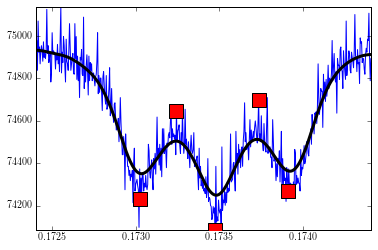

In [18]:
event = events_rp[0]


filt_data = gaussian_filter(event._data[:,1], sigma = sigma)
plt.plot(event._data[:,0], filt_data, c = 'black', lw = 3, zorder = 101)
plt.plot(event._data[:,0], event._data[:,1])
for i, extrema in enumerate(event._extrema):
    plt.scatter(event._data[extrema,0], event._data[extrema,1], c = 'red', s = 200, marker = 's', zorder = 100)
    
plt.xlim(event._data[0,0], event._data[-1,0])
plt.ylim(np.min(event._data[:,1]), np.max(event._data[:,1]))
    
plt.show()

# Get optical events

# Load events

In [5]:
sampling_freq_oi = 10000

In [6]:
reload(oi)
reload(oi_file)

vid_directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/vid/'
filepath_vid = vid_directory + 'HCT-116_pr0005_0000.mp4'

events_directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/events/'
filepath_events = events_directory+'hct-116_pr0005_0000_oi_events_raw'

events_oi_raw = oi_file.load_oi_events(filepath_events)

print len(events_oi_raw)

error!
line num =  78
<type 'exceptions.StopIteration'>
()

78


In [7]:
events_oi = copy.deepcopy(events_oi_raw)

# Set up stage

In [8]:
vid = oi_file.open_video_connection(filepath_vid)

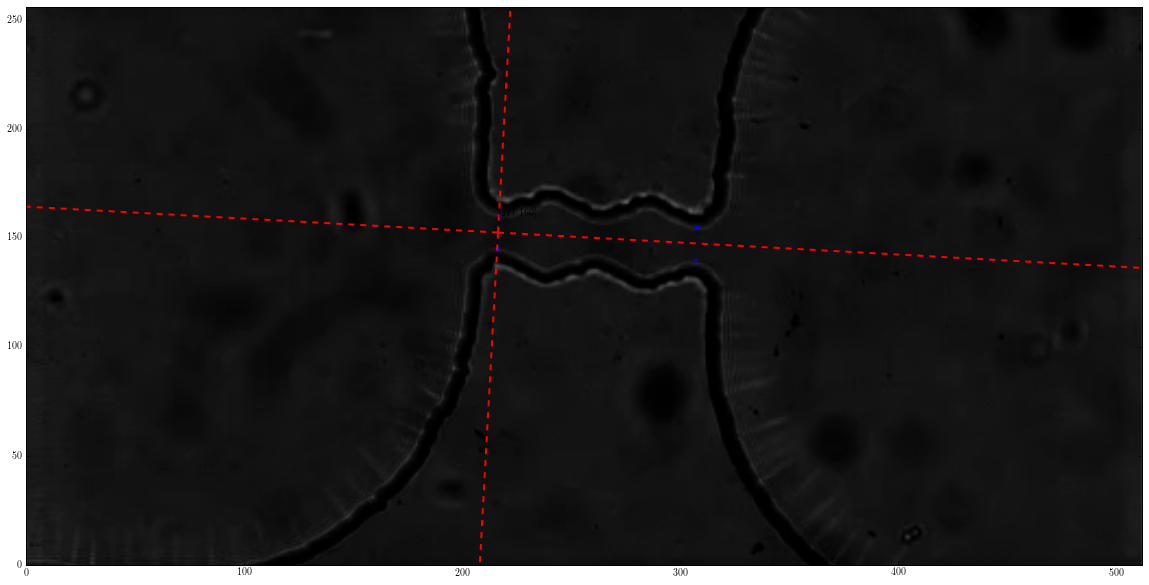

In [9]:
c0 = np.array([217, 160])
c1 = np.array([216, 145])
c2 = np.array([307, 140])
c3 = np.array([308, 155])

template_frame_num = 0
template_frame = oi.get_frame_vid(vid, template_frame_num)

stage = oi.Stage(template_frame, c0, c1, c2, c3)
stage.plot_stage()

# Event post-processing

In [10]:
print len(events_oi)
events_oi = oi.connect_loose_events(copy.deepcopy(events_oi), tf_sep_threshold = 10, dist_threshold = 50)
print len(events_oi)

78
52


oi_file.save_oi_events('/home/preston/Desktop/Science/Research/cancer_cells/data/7-20-2016/events/psmix_0013_oi_events',
                   events_oi)

# Remove events that don't enter, exit channel

In [12]:
for i, event in enumerate(events_oi):
    event.get_channel_enter_exit_tf(stage)
    
print len(events_oi)
events_oi = [event for event in events_oi if (event._channel_enter_tf != None) and (event._channel_exit_tf != None)]
print len(events_oi)

52
26


# Sort events by channel enter time

In [31]:
order = np.argsort(np.array([event._channel_enter_tf for event in events_oi]))
events_oi = [copy.deepcopy(events_oi[i]) for i in order]

# Multievent plot

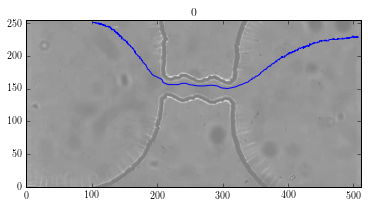

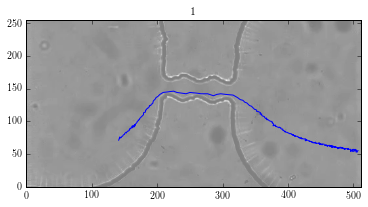

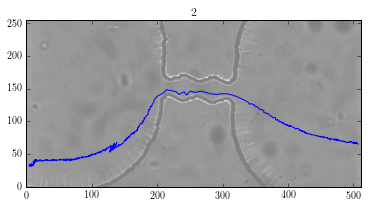

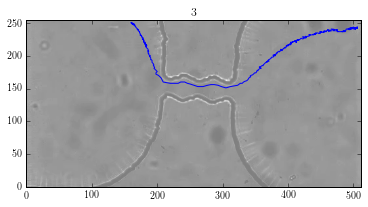

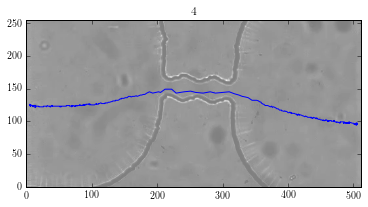

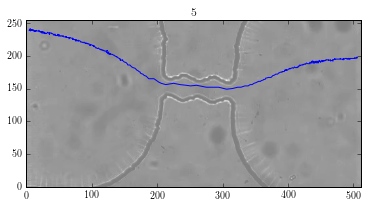

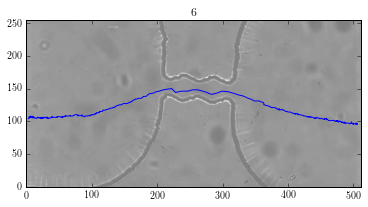

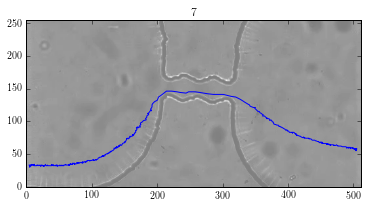

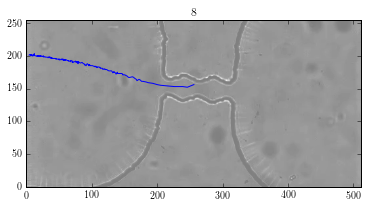

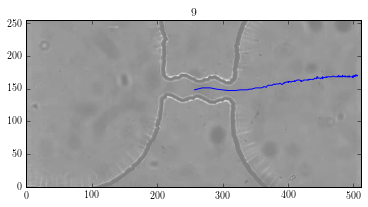

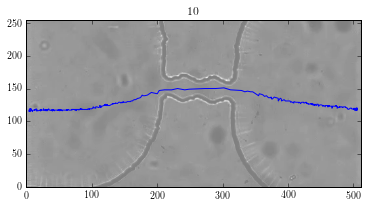

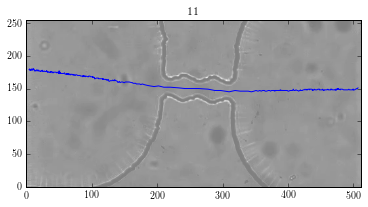

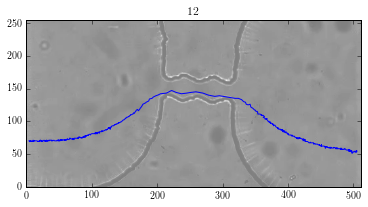

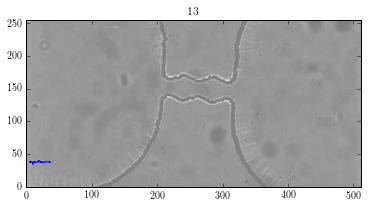

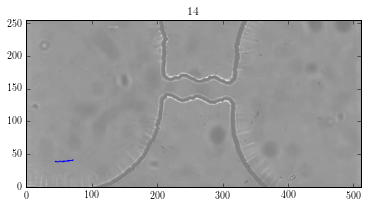

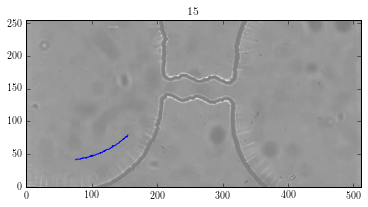

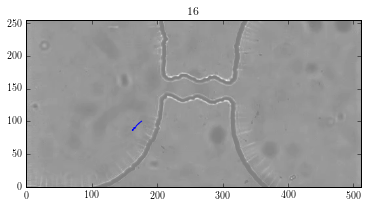

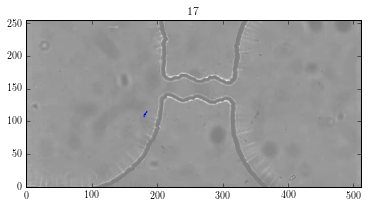

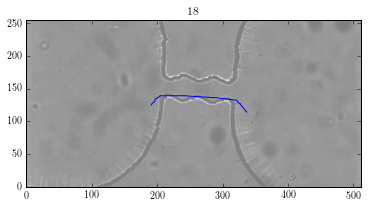

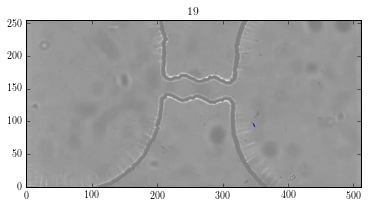

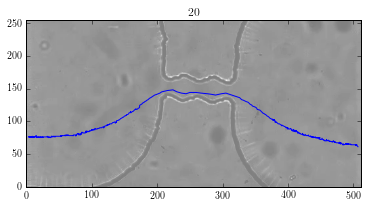

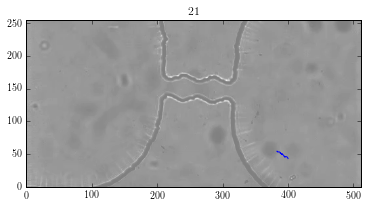

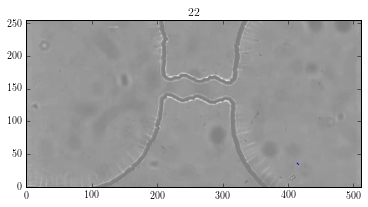

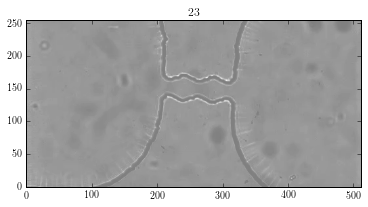

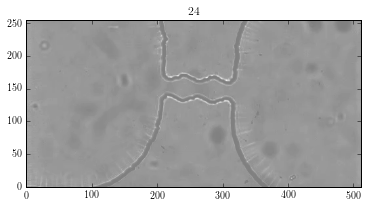

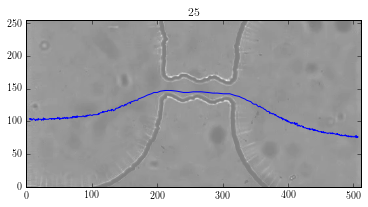

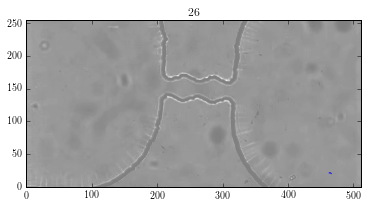

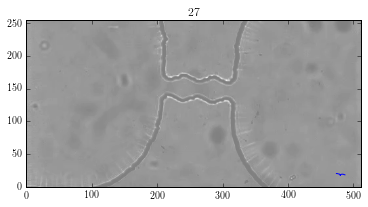

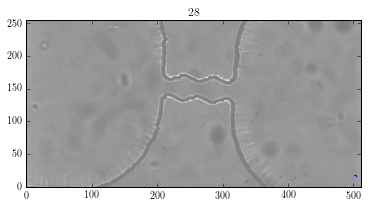

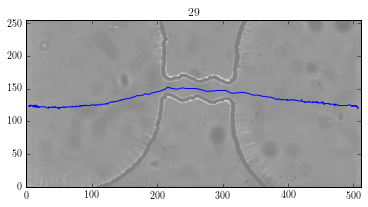

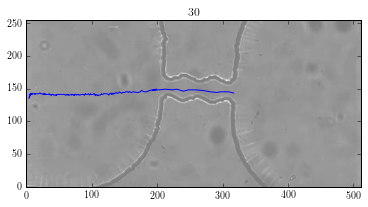

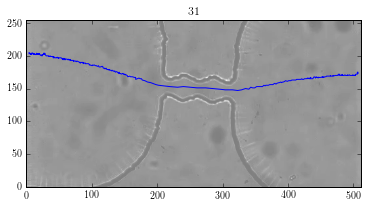

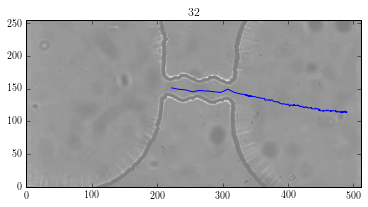

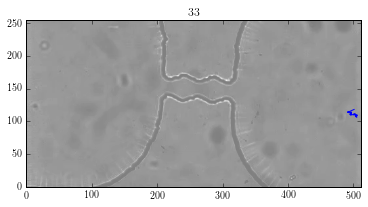

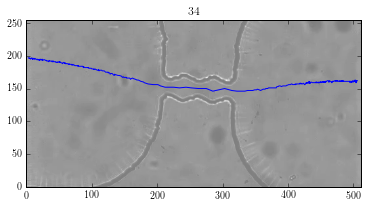

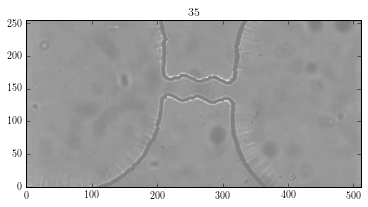

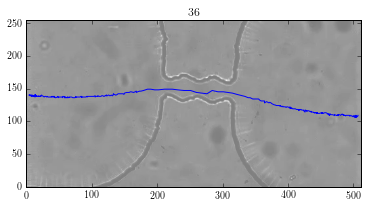

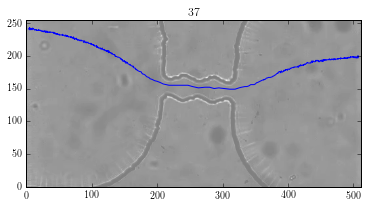

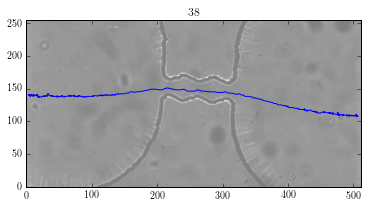

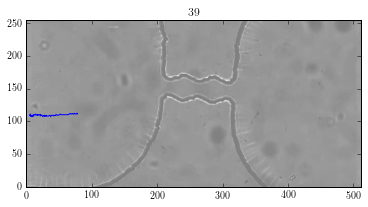

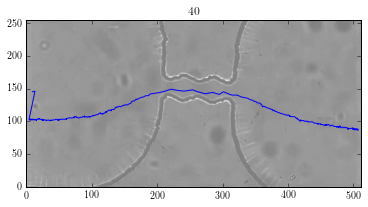

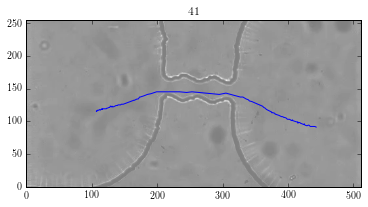

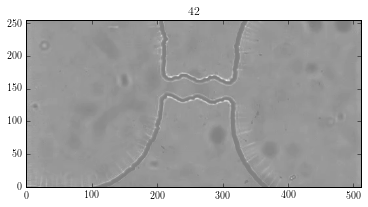

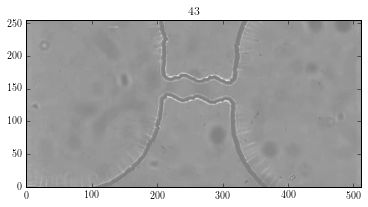

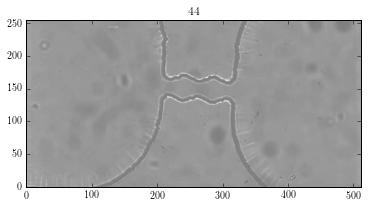

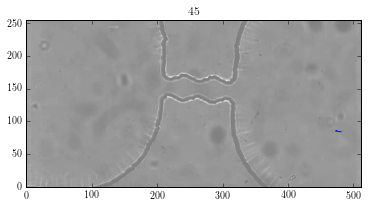

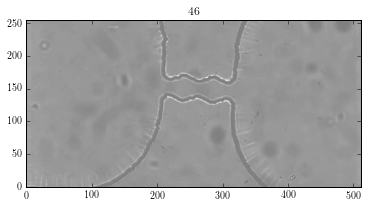

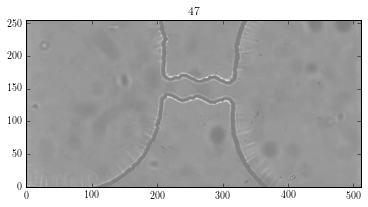

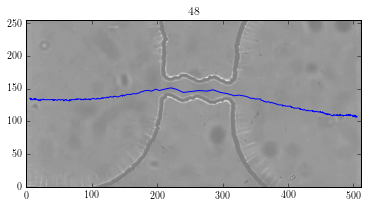

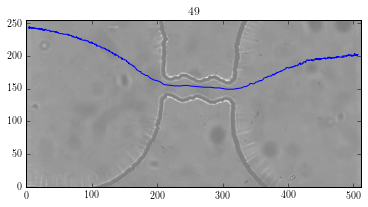

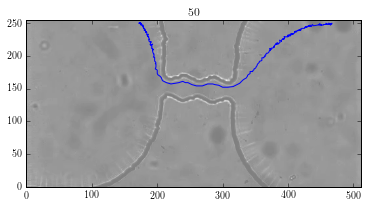

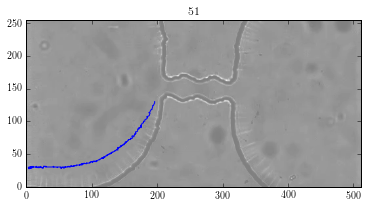

In [11]:
for i, event in enumerate(events_oi[:]):
    plt.plot(event.get_px(), event.get_py())
    plt.imshow(template_frame, alpha=0.5, cmap = 'gray', origin = 'lower')
    plt.title(str(i))

    plt.show()

# Channel enter positions

In [17]:
ypos = []
for i, event in enumerate(events_oi):
    x = event._detections[event._channel_enter_index]._px
    y = event._detections[event._channel_enter_index]._py
    ypos.append(stage.get_channel_coordinates(x,y)[1])

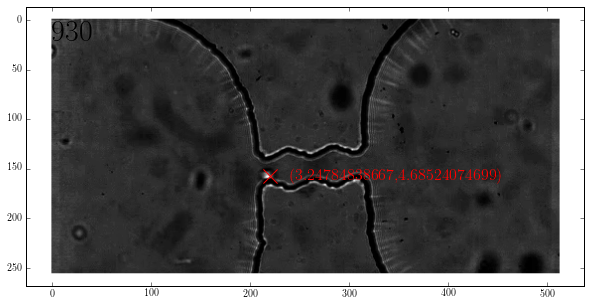

(3.2478483866689878, 4.6852407469853299)


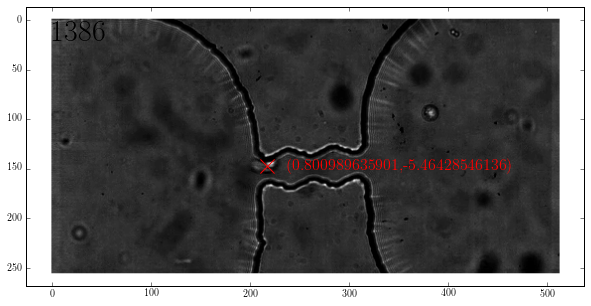

(0.80098963590147321, -5.4642854613552565)


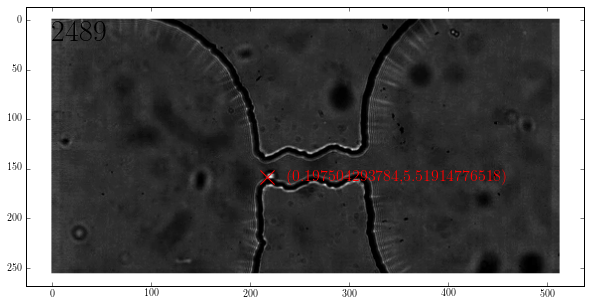

(0.19750429378392492, 5.5191477651841243)


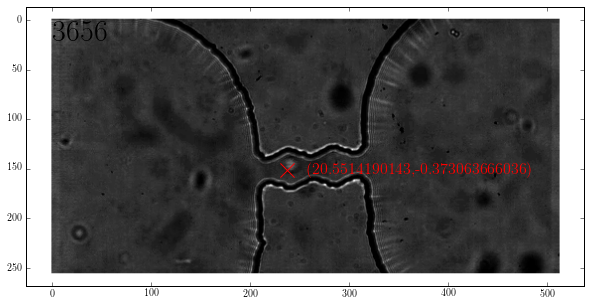

(20.551419014293963, -0.3730636660363027)


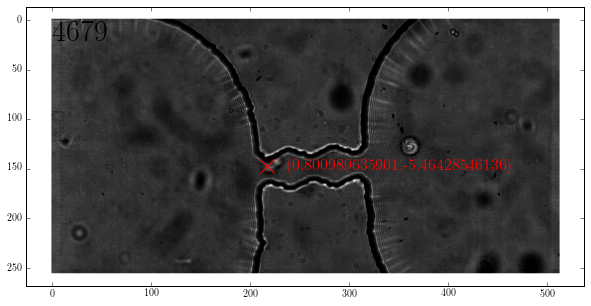

(0.80098963590147321, -5.4642854613552565)


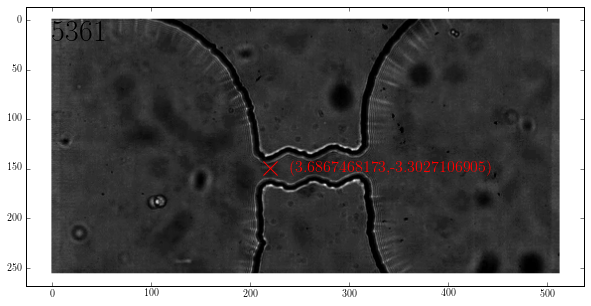

(3.686746817299932, -3.3027106904978556)


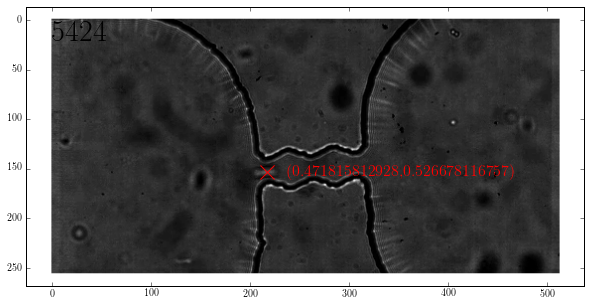

(0.47181581292826508, 0.52667811675713305)


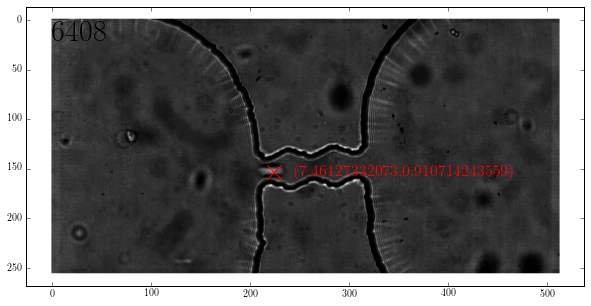

(7.4612733207260522, 0.91071424355920927)


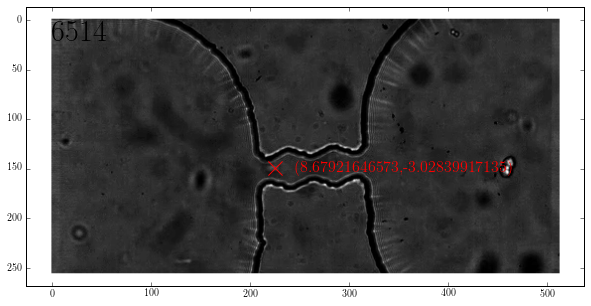

(8.6792164657269222, -3.0283991713535157)


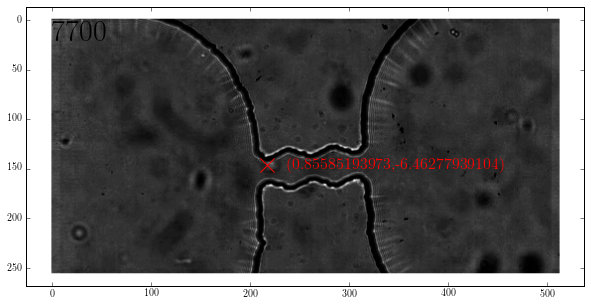

(0.85585193973034124, -6.4627793910406544)


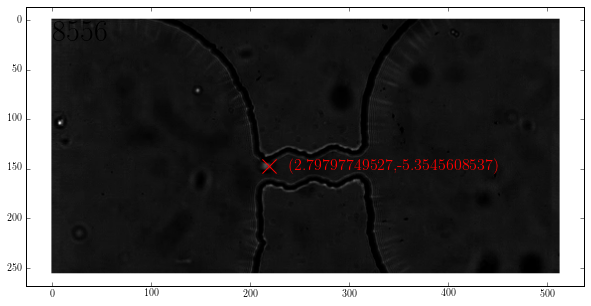

(2.7979774952722698, -5.35456085369752)


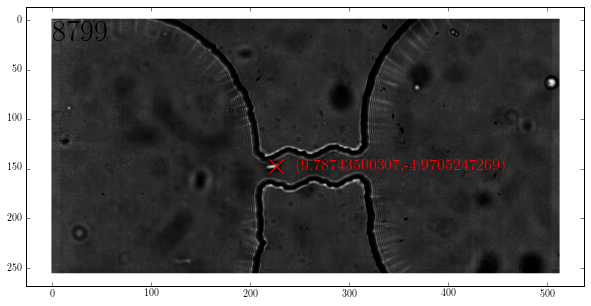

(9.7874350030700565, -4.9705247268954444)


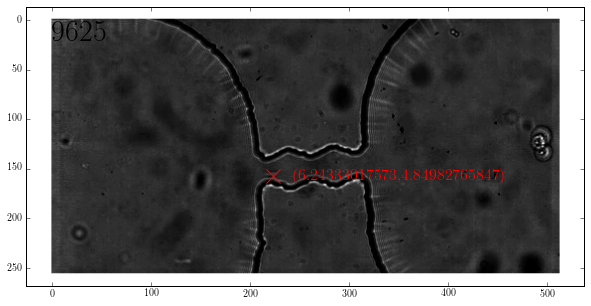

(6.2433301757251822, 4.8498276584719342)


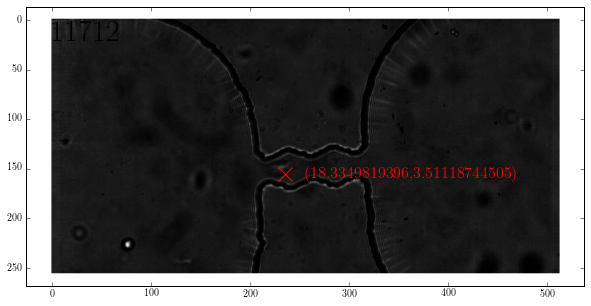

(18.334981939607697, 3.511187445047554)


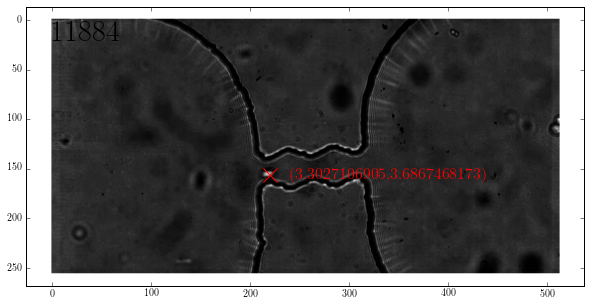

(3.3027106904978556, 3.686746817299932)


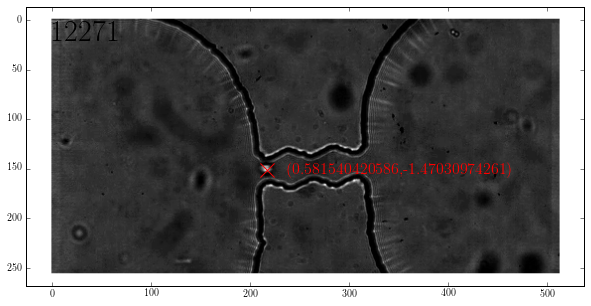

(0.58154042058600108, -1.4703097426136633)


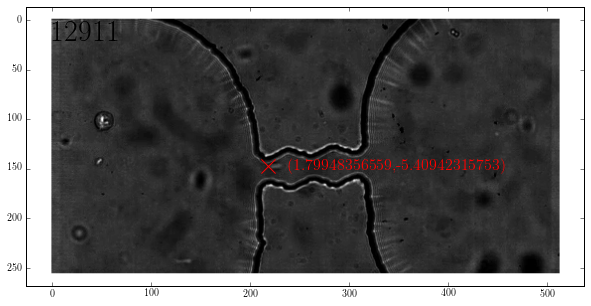

(1.7994835655868715, -5.4094231575263887)


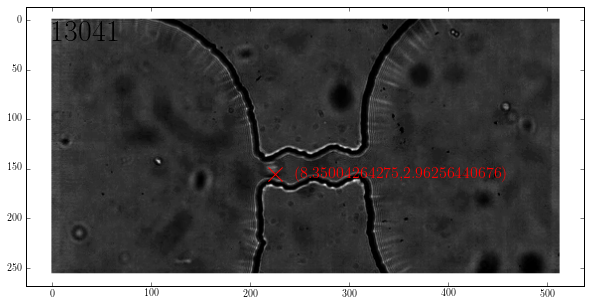

(8.3500426427537136, 2.9625644067588737)


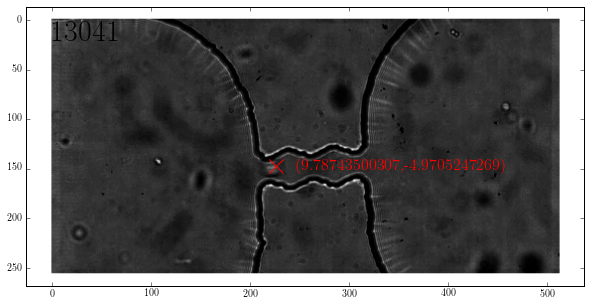

(9.7874350030700565, -4.9705247268954444)


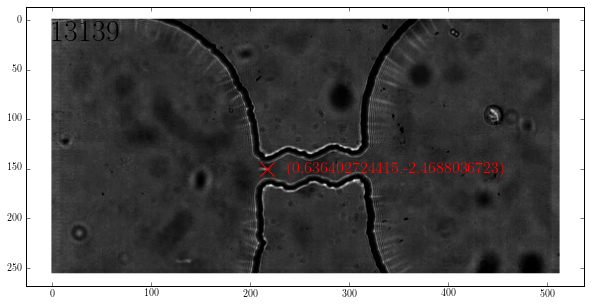

(0.63640272441486911, -2.4688036722990616)


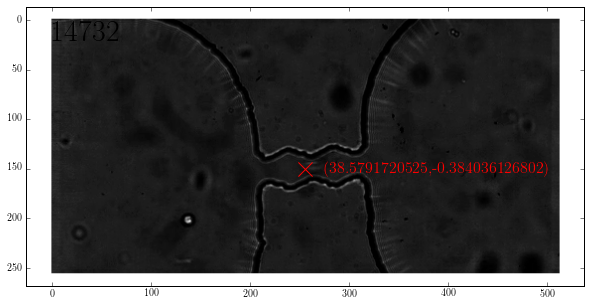

(38.579172052459995, -0.38403612680207644)


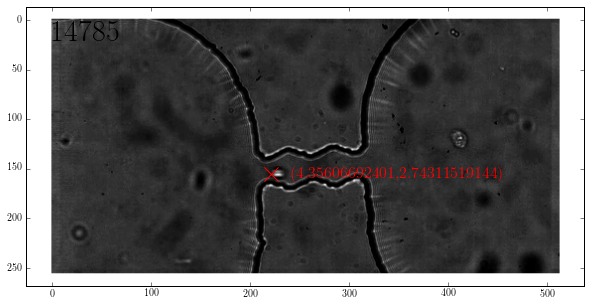

(4.3560669240121213, 2.7431151914434015)


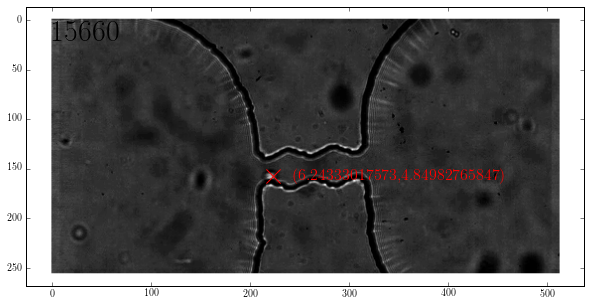

(6.2433301757251822, 4.8498276584719342)


In [18]:
for i, event in enumerate(events_oi):
    fig = plt.figure(figsize = (10,6))
    plt.imshow(oi.get_frame_vid(vid, int(event._channel_enter_tf)), cmap = 'gray')
    x = event._detections[event._channel_enter_index]._px
    y = event._detections[event._channel_enter_index]._py

    x_c, y_c = stage.get_channel_coordinates(x,y)
    plt.scatter(x,y, marker = 'x', color = 'red', s = 200)
    plt.text(0,0,str(event._channel_enter_tf), ha = 'left', va = 'top', size = 30)
    offset = 20
    plt.text(x+offset,y, '(' + str(x_c) + ',' + str(y_c) + ')', ha = 'left', va = 'center', color = 'red', size = 16)
    plt.show()
    print stage.get_channel_coordinates(x, y)

# Synchronize with resistive pulse data

In [19]:
print .587*vid._meta['nframes']/10000.0

0.9523488


In [20]:
for i, event in enumerate(events_rp):
    print i, event._data[0,0]

0 0.172404
1 0.198508
2 0.314848
3 0.325864
4 0.35972
5 0.423844
6 0.613788
7 0.70104
8 0.704784
9 0.744968
10 0.783788
11 0.803616
12 0.82288
13 0.917896
14 1.039136
15 1.070636
16 1.080772
17 1.132584
18 1.258512
19 1.429036
20 1.468904
21 1.47386
22 1.584676
23 1.701268
24 1.735708
25 1.801208
26 1.803572
27 1.878456
28 1.976748
29 1.987184
30 2.106116
31 2.191432
32 2.215964
33 2.2807
34 2.38062
35 2.3944
36 2.46998
37 2.502792
38 2.507004
39 2.52446
40 2.563032
41 2.627344
42 2.639836
43 2.808708
44 2.814408
45 2.901764
46 2.958668
47 3.015304
48 3.044428
49 3.068784
50 3.159716
51 3.183676
52 3.191356
53 3.198508
54 3.273528
55 3.31794
56 3.399888
57 3.42866
58 3.512984
59 3.525052
60 3.541812
61 3.546012
62 3.577356
63 3.593012
64 3.62368
65 3.684272
66 3.701284
67 3.711996
68 3.774244
69 3.794692
70 3.972952
71 4.1258
72 4.184056
73 4.214804
74 4.328836
75 4.42172
76 4.46538
77 4.474192
78 4.517332
79 4.589236
80 4.59964
81 4.853372
82 4.884264
83 4.932088
84 5.10092
85 5.13558

rp: 144
oi: 26


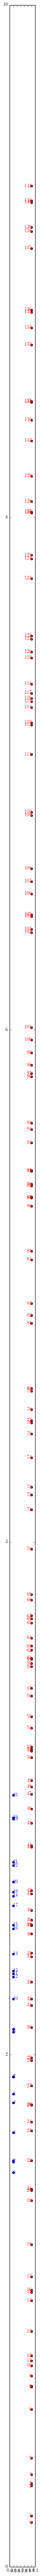

In [21]:
fig = plt.figure(figsize = (1,100))
oi_match = 2
rp_match = 22
offset = -1.*events_oi[oi_match]._channel_enter_tf/sampling_freq_oi + events_rp[rp_match]._data[events_rp[rp_match]._extrema[0],0] 
#offset = 0


print 'rp:', len(events_rp)
for i, event in enumerate(events_rp):
    plt.scatter(1, event._data[event._extrema[0],0], c = 'red')
    plt.text(1, event._data[event._extrema[0],0], str(i), ha = 'right', va = 'center', color = 'red')

print 'oi:', len(events_oi)
for i, event in enumerate(events_oi):    
    plt.scatter(.5, 1.*event._channel_enter_tf/sampling_freq_oi+offset, c = 'blue')
    plt.text(.5, 1.*event._channel_enter_tf/sampling_freq_oi+offset, str(i), ha = 'left', va = 'center', color = 'blue')

plt.xlim(.4,1.1)
plt.ylim(0,10)
    
plt.show()




In [22]:
plt.imshow(oi.get_frame_vid(vid, events_oi[41]._channel_enter_tf), cmap = 'gray')

IndexError: list index out of range

# Pairs

In [27]:
pairs = [
    (0,19),
    (1,21),
    (2,22),
    (3,28),
    (4,31),
    (5,32),
    (7,39),
    (8,40),
    (9,41),
    (11,44),
    (12,45)]

# Plot synced OI and RP 

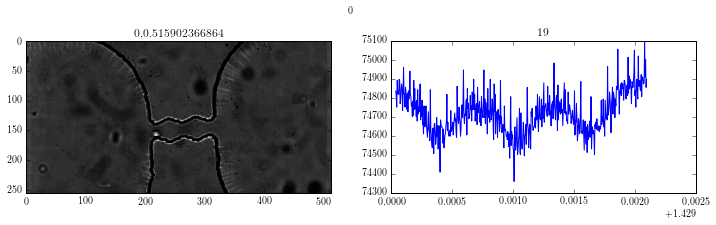

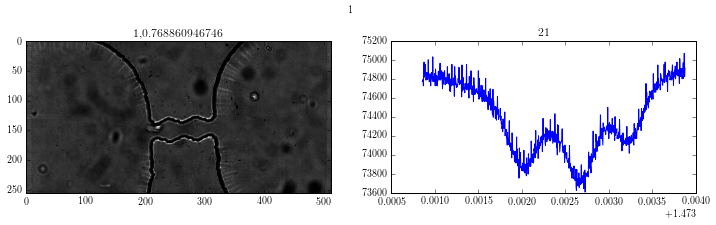

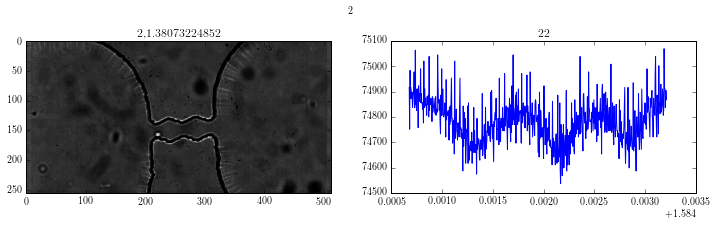

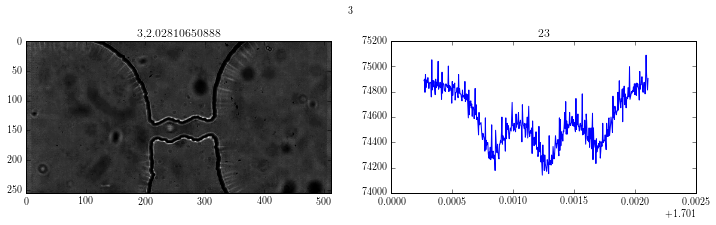

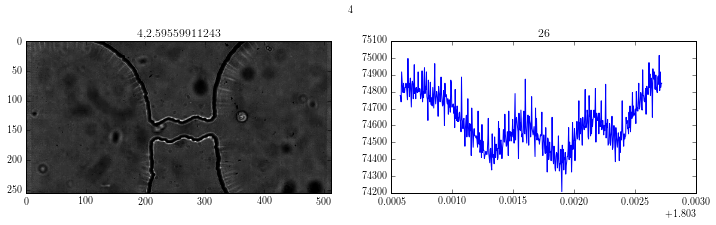

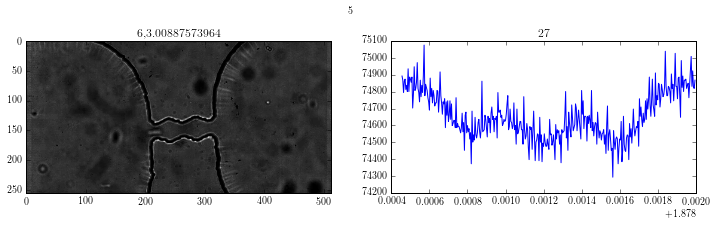

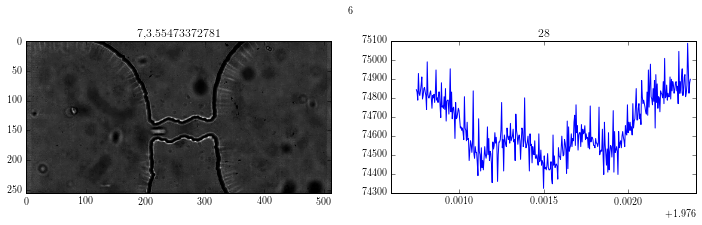

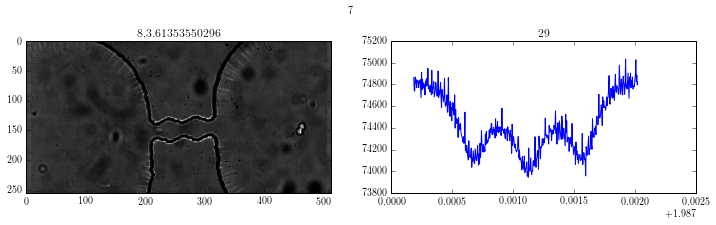

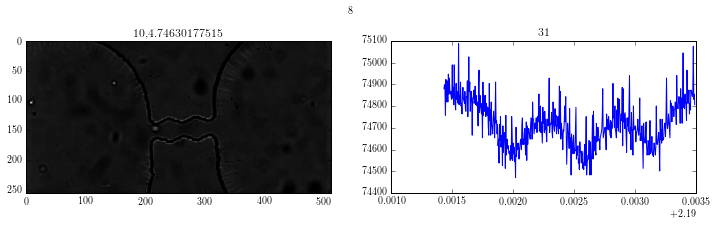

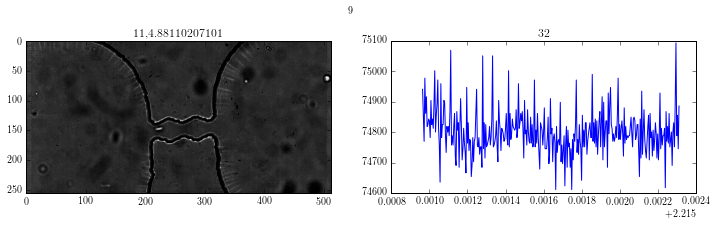

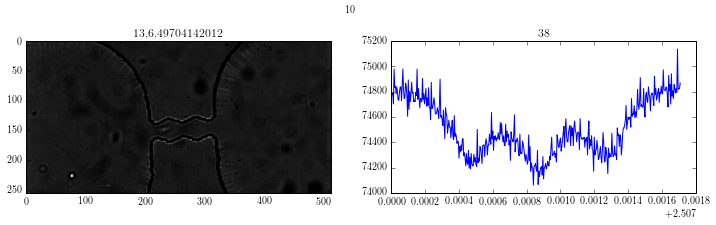

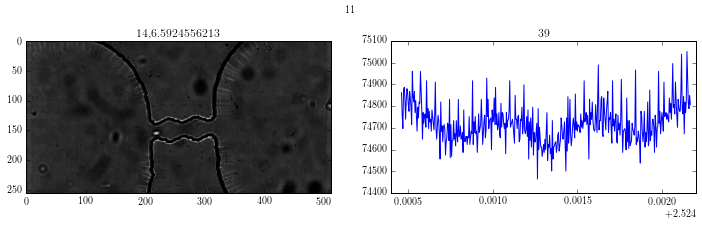

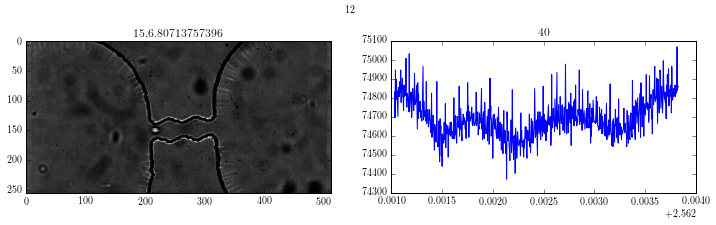

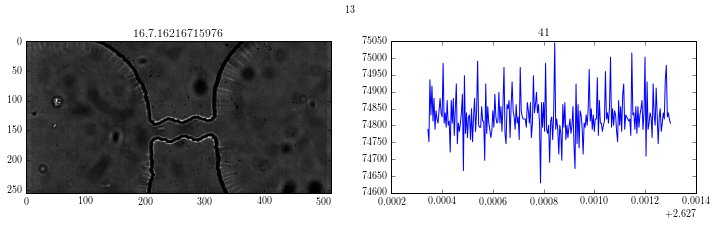

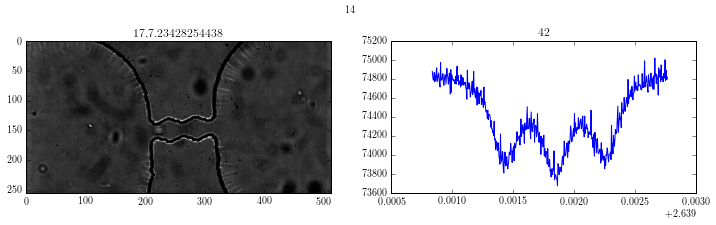

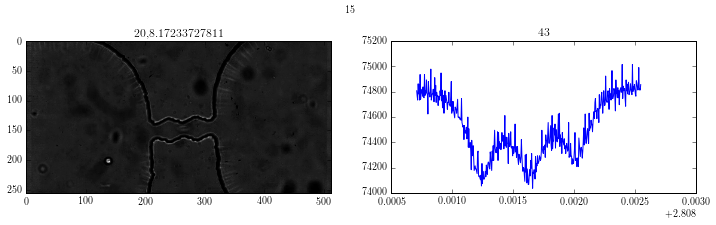

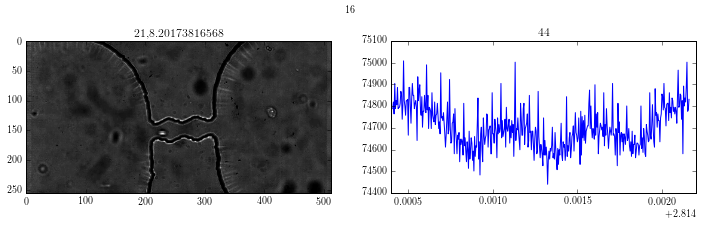

In [24]:
for i, pair in enumerate(pairs):
    
    event_oi = events_oi[pair[0]]
    event_rp = events_rp[pair[1]]
    
    
    fig = plt.figure(figsize = (12,6))
    fig.suptitle(i)
    gs=gridspec.GridSpec(2,2)
    
    
    
    plt.subplot(gs[0])
    plt.imshow(oi.get_frame_vid(vid, event_oi._channel_enter_tf), cmap = 'gray')
    plt.title(str(pair[0])+',' + str(1.*event_oi._channel_enter_tf/vid._meta['nframes']*9.))
    
    plt.subplot(gs[1])
    plt.plot(event_rp._data[:,0], event_rp._data[:,1])
    plt.title(str(pair[1]))
    
    plt.plot()
    plt.show()

# Entry position histograms

In [ ]:
fig = plt.figure(figsize = (8,6))
ys = []
for i, event in enumerate(events_oi):
    index = event._channel_enter_index
    x, y = stage.get_channel_coordinates(event._detections[index]._px, event._detections[index]._py)
    ys.append(y)

plt.hist(ys, bins = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])-0.5, color = (.2,.2,.2))

plt.title('Entry position frequency', size = title_size)
plt.xlabel('entry position (pix)', size = axislabel_size)
plt.ylabel('frequency', size = axislabel_size)



plt.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.savefig('/home/preston/Desktop/Science/Research/pore_stats/entry_positions_7-20-2016_psmix-0013.png', dpi = 300)

plt.show()

# Trajectory RP

In [ ]:
fig = plt.figure(figsize=(6, 12))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
index_1 = 46
for pair in pairs:
    if pair[0] == index_1:
        index_2 = pair[1]
event_oi = events_oi[index_1]
event_rp = events_rp[index_2]

#ax0 = fig.add_subplot(2,1,1)
ax0 = plt.subplot(gs[0])
plt.gca()

plt.imshow(template_frame, cmap = 'gray', aspect = 'auto', origin = 'lower')



tf_1 = int(event_oi._channel_enter_tf - event_oi._detections[0]._tf - (event_rp._extrema[0])/250000.0*10000.)

tf_2 = int(event_oi._channel_enter_tf - event_oi._detections[0]._tf + (event_rp._data.shape[0]-event_rp._extrema[0])/250000.0*10000.0)

trajectories = np.empty((tf_2-tf_1,2))

for i in range(tf_1, tf_2):
    trajectories[i-tf_1,0]=event_oi._detections[i]._px
    trajectories[i-tf_1,1]=event_oi._detections[i]._py


plt.plot(trajectories[:,0], trajectories[:,1])
    
plt.xlim(trajectories[0,0],trajectories[-1,0])
plt.ylim(34,90)

ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])

ax1 = plt.subplot(gs[1])
plt.gca()



plt.plot(event_rp._data[:,0], event_rp._data[:,1])

plt.xlim(event_rp._data[0,0], event_rp._data[-1,0])
plt.ylim(np.min(event_rp._data[:,1]), np.max(event_rp._data[:,1]))

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

transFigure = fig.transFigure.inverted()


"""
x0 = event_oi._detections[event_oi._channel_enter_index]._px
y0 = event_oi._detections[event_oi._channel_enter_index]._py
x1 = event_rp._data[event_rp._extrema[0],0]
y1 = event_rp._data[event_rp._extrema[0],1]
coord1 = transFigure.transform(ax0.transData.transform([x0,y0]))
coord2 = transFigure.transform(ax1.transData.transform([x1,y1]))


line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                               transform=fig.transFigure, c = 'red', lw = 3)
fig.lines.append(line)
"""

plt.tight_layout()

# Entry position vs. amplitude

In [ ]:
data = np.empty((len(pairs),2))

for i, pair in enumerate(pairs):
    event_oi = events_oi[pair[0]]
    event_rp = events_rp[pair[1]]
    
    amp = event_rp._data[:,1].max() - event_rp._data[:,1].min()
    
    
    index = event_oi._channel_enter_index
    x = event_oi._detections[index]._px
    y = event_oi._detections[index]._py
    xc, yc = stage.get_channel_coordinates(x,y)
    
    data[i,0] = yc
    data[i,1] = amp
    
fig = plt.figure(figsize = (8,6))
    
plt.scatter(data[:,0], data[:,1], c = 'black')

plt.xlabel('Entry position (pix)', size = axislabel_size)
plt.ylabel(r'Amplitude $\left(\mu A\right)$', size = axislabel_size)

plt.tick_params(axis = 'both', which = 'major', labelsize = axistick_size)

plt.grid()

plt.show()

# Entry y vs. translocation time scatter

In [ ]:
duration_list = []
sampling_freq_oi = 10000
yc = []
for i in range(len(events_oi)):
    duration_list.append(1.*(events_oi[i]._channel_exit_tf - events_oi[i]._channel_enter_tf)/sampling_freq_oi)
    
    x = events_oi[i]._detections[events_oi[i]._channel_enter_index]._px
    y = events_oi[i]._detections[events_oi[i]._channel_enter_index]._py
    yc.append(stage.get_channel_coordinates(x,y)[1])

fig = plt.figure(figsize = (8,6))
    
plt.scatter(yc, duration_list, c = 'black')

plt.xlim(-10,10)
plt.ylim(0,.01)

plt.title('Entry position vs translocation duration', size = title_size)

plt.tick_params(axis = 'both', which = 'major', labelsize = axistick_size)

plt.xlabel('Entry position (pix)', size = axislabel_size)
plt.ylabel('Duration (s)', size = axislabel_size)

plt.grid()

plt.show()

# x vs. t plot

In [ ]:
import matplotlib as mpl

In [ ]:
fig = plt.figure(figsize = (8,6))

Z = [[0,0],[0,0]]
levels = range(0,14)


cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', color_range)



CS3 = plt.contourf(Z, levels, cmap = cmap)




plt.clf()


for i, event in enumerate(events_oi[:]):
    i1 = event._channel_enter_index
    i2 = event._channel_exit_index
    px = event.get_px()
    py = event.get_py()
    xcs = []
    for j in range(i1,i2):
        xc, yc = stage.get_channel_coordinates(px[j], py[j])
        xcs.append(xc)
        if j == i1:
            enter_yc = yc+8
            
    

    plt.plot(1.*(np.array(event.get_tf()[i1:i2]) - event._detections[i1]._tf)/sampling_freq_oi, xcs,\
             color = color_range[int(enter_yc)-1],\
             zorder = 100)
    
    
    
plt.tick_params(axis = 'both', which = 'major', labelsize = axistick_size)
    
plt.title('axis position vs time', size = title_size)
plt.xlabel('t (s)', size = axislabel_size)
plt.ylabel('x (pix)', size = axislabel_size)
plt.grid()



plt.colorbar(CS3)



plt.show()

# v vs. t plot

In [ ]:
for i, event in enumerate(events_oi[:10]):
    i1 = event._channel_enter_index
    i2 = event._channel_exit_index
    px = event.get_px()
    py = event.get_py()
    xcs = []
    for j in range(i1,i2):
        xc, yc = stage.get_channel_coordinates(px[j], py[j])
        xcs.append(xc)
        if j == i1:
            enter_yc = yc+8
            
    vs = []
    for j in range(1, i2-i1-1):
        vs.append(((xcs[j+1] - xcs[j])+(xcs[j+1] - xcs[j-1])/2.)/2.)
        

    

    plt.plot(1.*(np.array(event.get_tf()[i1+1:i2-1]) - event._detections[i1]._tf)/sampling_freq_oi, vs)
    
    plt.xlabel('time (s)')
    plt.ylabel('')
    plt.show()

## Animation vers. 1

In [28]:
def get_rp_index(oi_index, oi_sync_index, rp_sync_index, oi_sampling_freq, rp_sampling_freq):
    return int(rp_sync_index + 1.*(oi_index - oi_sync_index)/oi_sampling_freq*rp_sampling_freq)

In [29]:
filepath_rp = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/bts/HCT116_pr0005_0000.bts'
data_rp = rp_file.get_data(filepath_rp)

910 963
910
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
1366 1419
1366
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
2469 2525
2469
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
6388 6436
6388
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6

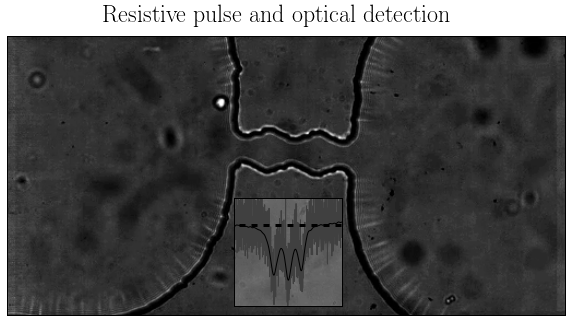

In [30]:
for index in range(len(pairs)):
    plt.clf()
    event_oi = events_oi[pairs[index][0]]
    event_rp = events_rp[pairs[index][1]]

    i_oi_0 = event_oi._channel_enter_tf - 20
    i_oi_1 = event_oi._channel_enter_tf
    i_oi_2 = event_oi._channel_exit_tf + 20


    i_rp_1 = int(event_rp._data[event_rp._extrema[0],0]*250000.0)
    i_rp_0 = int(i_rp_1 - (i_oi_1 - i_oi_0)*250000.0/10000.0)
    i_rp_2 = int(i_rp_1 + (i_oi_2 - i_oi_1)*250000.0/10000.0)

    trajectories = np.zeros((i_oi_2-i_oi_0,2))
    print i_oi_0, i_oi_2
    for i in range(i_oi_0,i_oi_2):
        try:
            trajectories[i-i_oi_0,:] = np.array([event_oi.get_detection(i)._px, event_oi.get_detection(i)._py])
        except:
            trajectores[i-i_oi_0,:] = trajectories[i-1,:]
            pass


    # Set up figure and subplots
    fig = plt.figure(num = 0, figsize = (10,5))
    fig.suptitle('Resistive pulse and optical detection', fontsize = 24)

    fig.subplots_adjust(wspace = None, hspace = None)

    # Initialize plot0
    ax0 = plt.subplot()
    ax0.grid(False)
    ax0.set_xticks([])
    ax0.set_yticks([])

    plot_0 = ax0.imshow(oi.get_frame_vid(vid, event_oi._detections[0]._tf), cmap = 'gray', aspect = 'auto', origin = 'lower')
    plot_1, = ax0.plot(0,0, color = (1.,0,0), zorder = 2)
    plot_0.axes.set_xlim(0, template_frame.shape[1])
    plot_0.axes.set_ylim(0, template_frame.shape[0])
    plot_1.axes.set_xlim(0, template_frame.shape[1])
    plot_1.axes.set_ylim(0, template_frame.shape[0])



    # Initialize plot 2
    left,bottom,width,height = [0.44,0.15,0.15,0.3]
    ax1 = fig.add_axes([left,bottom,width,height])
    ax1.patch.set_facecolor((1,1,1))
    ax1.patch.set_alpha(0.25)
    ax1.set_xticks([])
    ax1.set_yticks([])


    ax1.plot([0,10], [event_rp._baseline[1], event_rp._baseline[1]], ls = '--', color = 'black', lw = 3, zorder = 2)
    filt_data = gaussian_filter(data_rp[i_rp_0:i_rp_2,1], sigma = sigma)
    ax1.plot(data_rp[i_rp_0:i_rp_2,0], filt_data, color = 'black', zorder = 3)
    ax1.plot(data_rp[i_rp_0:i_rp_2,0], data_rp[i_rp_0:i_rp_2,1], zorder = 1, color = (.25,.25,.25))

    plot_2, = ax1.plot(event_rp._data[0,0], event_rp._data[0,1], zorder = 2, color = (1.,0,0))


    def get_frame_data(frame):
        print frame

        # Set data for plot0
        plot_0.set_data(oi.get_frame_vid(vid, frame))  
        plot_1.set_data(trajectories[:frame-i_oi_0, 0],trajectories[:frame-i_oi_0, 1])

        index_rp = get_rp_index(frame, i_oi_1, i_rp_1, 10000, 250000)
        plot_2.set_data(data_rp[i_rp_0:index_rp,0], data_rp[i_rp_0:index_rp,1])
        plot_2.axes.set_xlim(data_rp[i_rp_0, 0], data_rp[i_rp_2, 0])
        plot_2.axes.set_ylim(event_rp._data[:,1].min(), event_rp._data[:,1].max())

        return plot_0, plot_1, plot_2

    ffmpeg_bin='/home/preston/ffmpeg-3.0.2-64bit-static/ffmpeg'
    plt.rcParams['animation.ffmpeg_path']=ffmpeg_bin
    video = animation.FuncAnimation(fig, get_frame_data, np.arange(i_oi_0, i_oi_2, 1))
    writer=animation.FFMpegWriter()
    video.save(filename = 'HCT-116_pr0005_0000_' + str(index) + '.mp4', writer = writer, fps = 60)